#### Import Libraries

In [2]:
import numpy as np
import networkx as nx
# import dynetx as dx
import math
import time
from scipy.interpolate import UnivariateSpline
import osmnx as ox
import matplotlib.pyplot as plt

#### Define Functions Used in Code

In [3]:
def time_expand(graph, time_int_size, num_time_int):
    start = time.time()
    orig_nodes = list(graph.nodes)
    orig_edges = list(graph.edges)
    ten = nx.DiGraph()
    node_num = 1
    for j in range(num_time_int):
        for i in range(1,len(orig_nodes)+1):
            node_name = f'{i}-{j}'
            ten.add_node(node_num, name = node_name, level = j)
            node_num += 1

    if graph.is_multigraph():
        node_num = 0
        for j in range(num_time_int-1):
            for i in range(1, len(orig_nodes)+1):
                node_num +=1
                for k in range(1, len(orig_nodes)+1):
                    for m in range(graph.number_of_edges(i,k)+1):
                        if (i,k,m) in orig_edges:
                            time_int_end = math.ceil(graph[i][k][m]['travel_time']/time_int_size)
                            if time_int_end+j< num_time_int:
                                ten.add_edge(node_num,node_num+(k-i)+(len(orig_nodes)*time_int_end),cost = graph[i][k][m]['cost'] ,upper = graph[i][k][m]['upper'], lower = 0)
        
    elif graph.is_directed():
        node_num = 0
        for j in range(num_time_int-1):
            for i in range(1, len(orig_nodes)+1):
                node_num +=1
                for k in range(1, len(orig_nodes)+1):
                    if (i,k) in orig_edges:
                        time_int_end = math.ceil(graph[i][k]['travel_time']/time_int_size)
                        if time_int_end+j< num_time_int:
                            ten.add_edge(node_num,node_num+(k-i)+(len(orig_nodes)*time_int_end),cost = graph[i][k]['cost'] ,upper = graph[i][k]['upper'], lower = 0)
    else:
        raise Exception("Must Input a DiGraph or MultiDiGraph")
        
    
    end = time.time()
    if end-start > 1:
        print('Number of Time Intervals:', num_time_int)
        print('Elasped Time: ',end-start, ' seconds')
    return ten

In [4]:
MOORE_AFTER_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [3.9, 6, 11, 18, 27, 39, 54, 58, 84],
)
MOORE_BEFORE_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [6, 8, 11, 14, 17, 19, 22, 25, 28],
)

MOORE_SAFE_BREAKING_DISTANCE = lambda x: MOORE_AFTER_BREAK_SPLINE(
    x
) + MOORE_BEFORE_BREAK_SPLINE(x)

def moore(lanes: float, max_speed: float):
    return 1000 * max_speed / MOORE_SAFE_BREAKING_DISTANCE(max_speed) * lanes

def add_capacities(G, method=moore):

    G = G.copy()
    cap = []
    
    for u, v, i in G.edges:
        edge_data = G.get_edge_data(u, v, i)
        raw_lanes = edge_data.get("lanes")
        
        if raw_lanes is None:
            lanes = 1
            
        elif isinstance(raw_lanes, str):
            lanes = int(raw_lanes) / 2  
            
        elif isinstance(raw_lanes, list):
            lanes = sum(int(x) for x in raw_lanes) / 2
            
        G[u][v][i]["upper"] = int(method(lanes, edge_data["speed_kph"]))
    return G

In [5]:
def add_costs(G, costs = 0):
    for u,v,i in G.edges:
        G[u][v][i]['cost'] = costs
    return G

### Toy Network Constructed

In [16]:
toy_net = nx.DiGraph()
toy_net.add_nodes_from(range(1,5))
toy_net.add_edges_from([(1,2),(1,3),(2,3),(2,4),(3,4)], cost = 0, upper = 3)
toy_net[1][2]['travel_time'] = 2
toy_net[1][3]['travel_time'] = 4
toy_net[2][3]['travel_time'] = 3
toy_net[2][4]['travel_time'] = 1
toy_net[3][4]['travel_time'] = 1

### Real-world Network Constructed

In [58]:
start = time.time()
#import data from osmnx, can input any city, state, etc.
G = ox.project_graph(ox.graph_from_place('Lyons Colorado', network_type='drive'))
print('Importing Network Complete')

#get rid of intersections that are not actually intersections
G = ox.simplification.consolidate_intersections(G, tolerance=10, rebuild_graph=True, dead_ends=True, reconnect_edges = True)
print('Simplication Complete')
#add edge speeds
G = ox.speed.add_edge_speeds(G)
print('Speed Added')

#add travel times
G = ox.speed.add_edge_travel_times(G)
print('Travel Time Added')

#add capacities (computed using moore method)
G = add_capacities(G)
print('Capacities Added')

G = add_costs(G)
print('Costs Added')

end = time.time()

print('Time to Build Original Network: ',end-start, ' seconds')

#G changes, so we want to have an original network to later plot the shortest paths on
# G_original=G.copy()

Importing Network Complete
Simplication Complete
Speed Added
Travel Time Added
Capacities Added
Costs Added
Time to Build Original Network:  0.8667480945587158  seconds


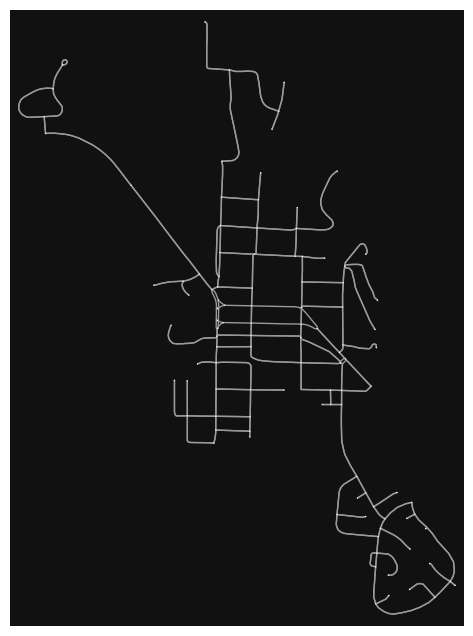

In [16]:
fig,ax = ox.plot_graph(G,show = False, close = False,node_size = 1)
plt.show()

### Test Time Expansion Functionality

In [17]:
test_ten = time_expand(toy_net,1,6)

In [73]:
test_rw_net = time_expand(G,5,5)

### Draw Time Expanded Network (TEN)

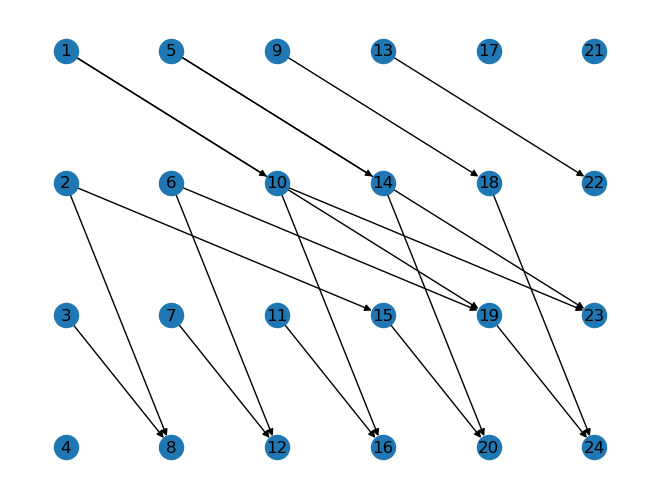

In [18]:
pos = nx.multipartite_layout(test_ten, subset_key="level")
nx.draw(test_ten, pos, with_labels=True)

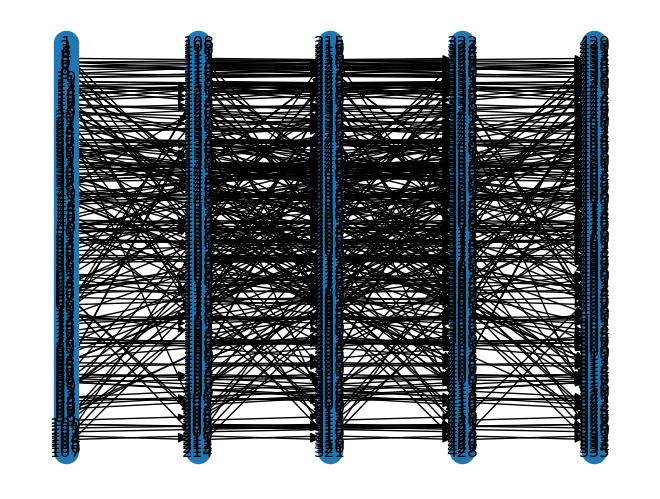

In [74]:
pos = nx.multipartite_layout(test_rw_net, subset_key="level")
nx.draw(test_rw_net, pos, with_labels=True)